In [254]:
import shap 
import torch 
import numpy as np 
from matplotlib import pyplot as plt 
import pandas as pd 
from torch.utils.data import DataLoader
import scipy
import torch_geometric as pyg 
import umap 
import seaborn as sbn
import networkx as nx 
from sklearn.decomposition import PCA
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import gseapy as gp
import pickle as pkl 

import sys 
sys.path.append('../')
import src.models.utils as utils
from src.data.LincsDataset import LincsDataset

from src.interpret.extract_entity_function import extract_entity_function

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# output/gsnn/09461877-9965-4dd8-a668-97f77ef73717
model = torch.load('../output/exp4-1/GSNN/ef2aa31f-0c57-4210-b12a-68859ed6b1d2/model.pt').cpu()
data = torch.load('../output/exp4-1/GSNN/ef2aa31f-0c57-4210-b12a-68859ed6b1d2/Data.pt')
proc = '../output/exp4-1/proc/'

In [3]:
ids = np.array(np.load(f'{proc}/train_obs.npy', allow_pickle=True).tolist() + np.load(f'{proc}/test_obs.npy', allow_pickle=True).tolist() + np.load(f'{proc}/val_obs.npy', allow_pickle=True).tolist())

dataset = LincsDataset(proc, ids)
loader = DataLoader(dataset, batch_size=100, shuffle=True)

X = []
sig_ids = []
for i,(x, y, sig_id) in enumerate(loader): 
    X.append(x)
    sig_ids += list(sig_id)

X = torch.cat(X, dim=0).squeeze()
X.size()

torch.Size([28052, 4988])

# Omic influence on LINCS prediction

We will look at a few RNA entity functions and inspect how OMIC nodes modify LINCS prediction. 

In [358]:
r_cell_gene_df = pd.DataFrame(pkl.load(open('../output/exp4-1/GSNN/ef2aa31f-0c57-4210-b12a-68859ed6b1d2/r_gene_dict.pkl', 'rb')), index=[0]).T.reset_index().rename({'index':'uniprot', 0:'r'}, axis=1)
r_cell_gene_df = r_cell_gene_df.sort_values(by='r', ascending=False)
r_cell_gene_df.head()


uniprot         r
323  Q14145  0.792349
199  P32321  0.754841
91   P04899  0.743068
7    O00762  0.716104
424  Q9NRC1  0.712247

['PROTEIN__P11831' 'PROTEIN__P19419' 'PROTEIN__P40763' 'PROTEIN__P03372'
 'PROTEIN__P16220' 'PROTEIN__P42224' 'PROTEIN__P42226' 'PROTEIN__P15336'
 'RNA__MIMAT0000099' 'RNA__MIMAT0004513' 'RNA__MIMAT0000278'
 'RNA__MIMAT0000279' 'RNA__MIMAT0000256' 'RNA__MIMAT0000257'
 'RNA__MIMAT0000252' 'RNA__MIMAT0000250' 'RNA__MIMAT0000100'
 'RNA__MIMAT0000646' 'RNA__MIMAT0000255' 'RNA__MIMAT0001080'
 'EXPR__P01100' 'METHYL__P01100' 'CNV__P01100' 'MUT__P01100']
RNA__P01100


100%|██████████| 1000/1000 [01:20<00:00, 12.47it/s]


####
['PROTEIN__P03372' 'RNA__MIMAT0000265' 'EXPR__O95238' 'METHYL__O95238'
 'CNV__O95238' 'MUT__O95238']
RNA__O95238


100%|██████████| 1000/1000 [00:31<00:00, 31.37it/s]


####
['PROTEIN__P03372' 'PROTEIN__P40763' 'PROTEIN__P42224' 'EXPR__P04792'
 'METHYL__P04792' 'CNV__P04792' 'MUT__P04792']
RNA__P04792


100%|██████████| 1000/1000 [00:29<00:00, 33.95it/s]


####
['PROTEIN__P18146' 'RNA__MIMAT0000420' 'EXPR__P04040' 'METHYL__P04040'
 'CNV__P04040' 'MUT__P04040']
RNA__P04040


100%|██████████| 1000/1000 [00:32<00:00, 31.18it/s]


####


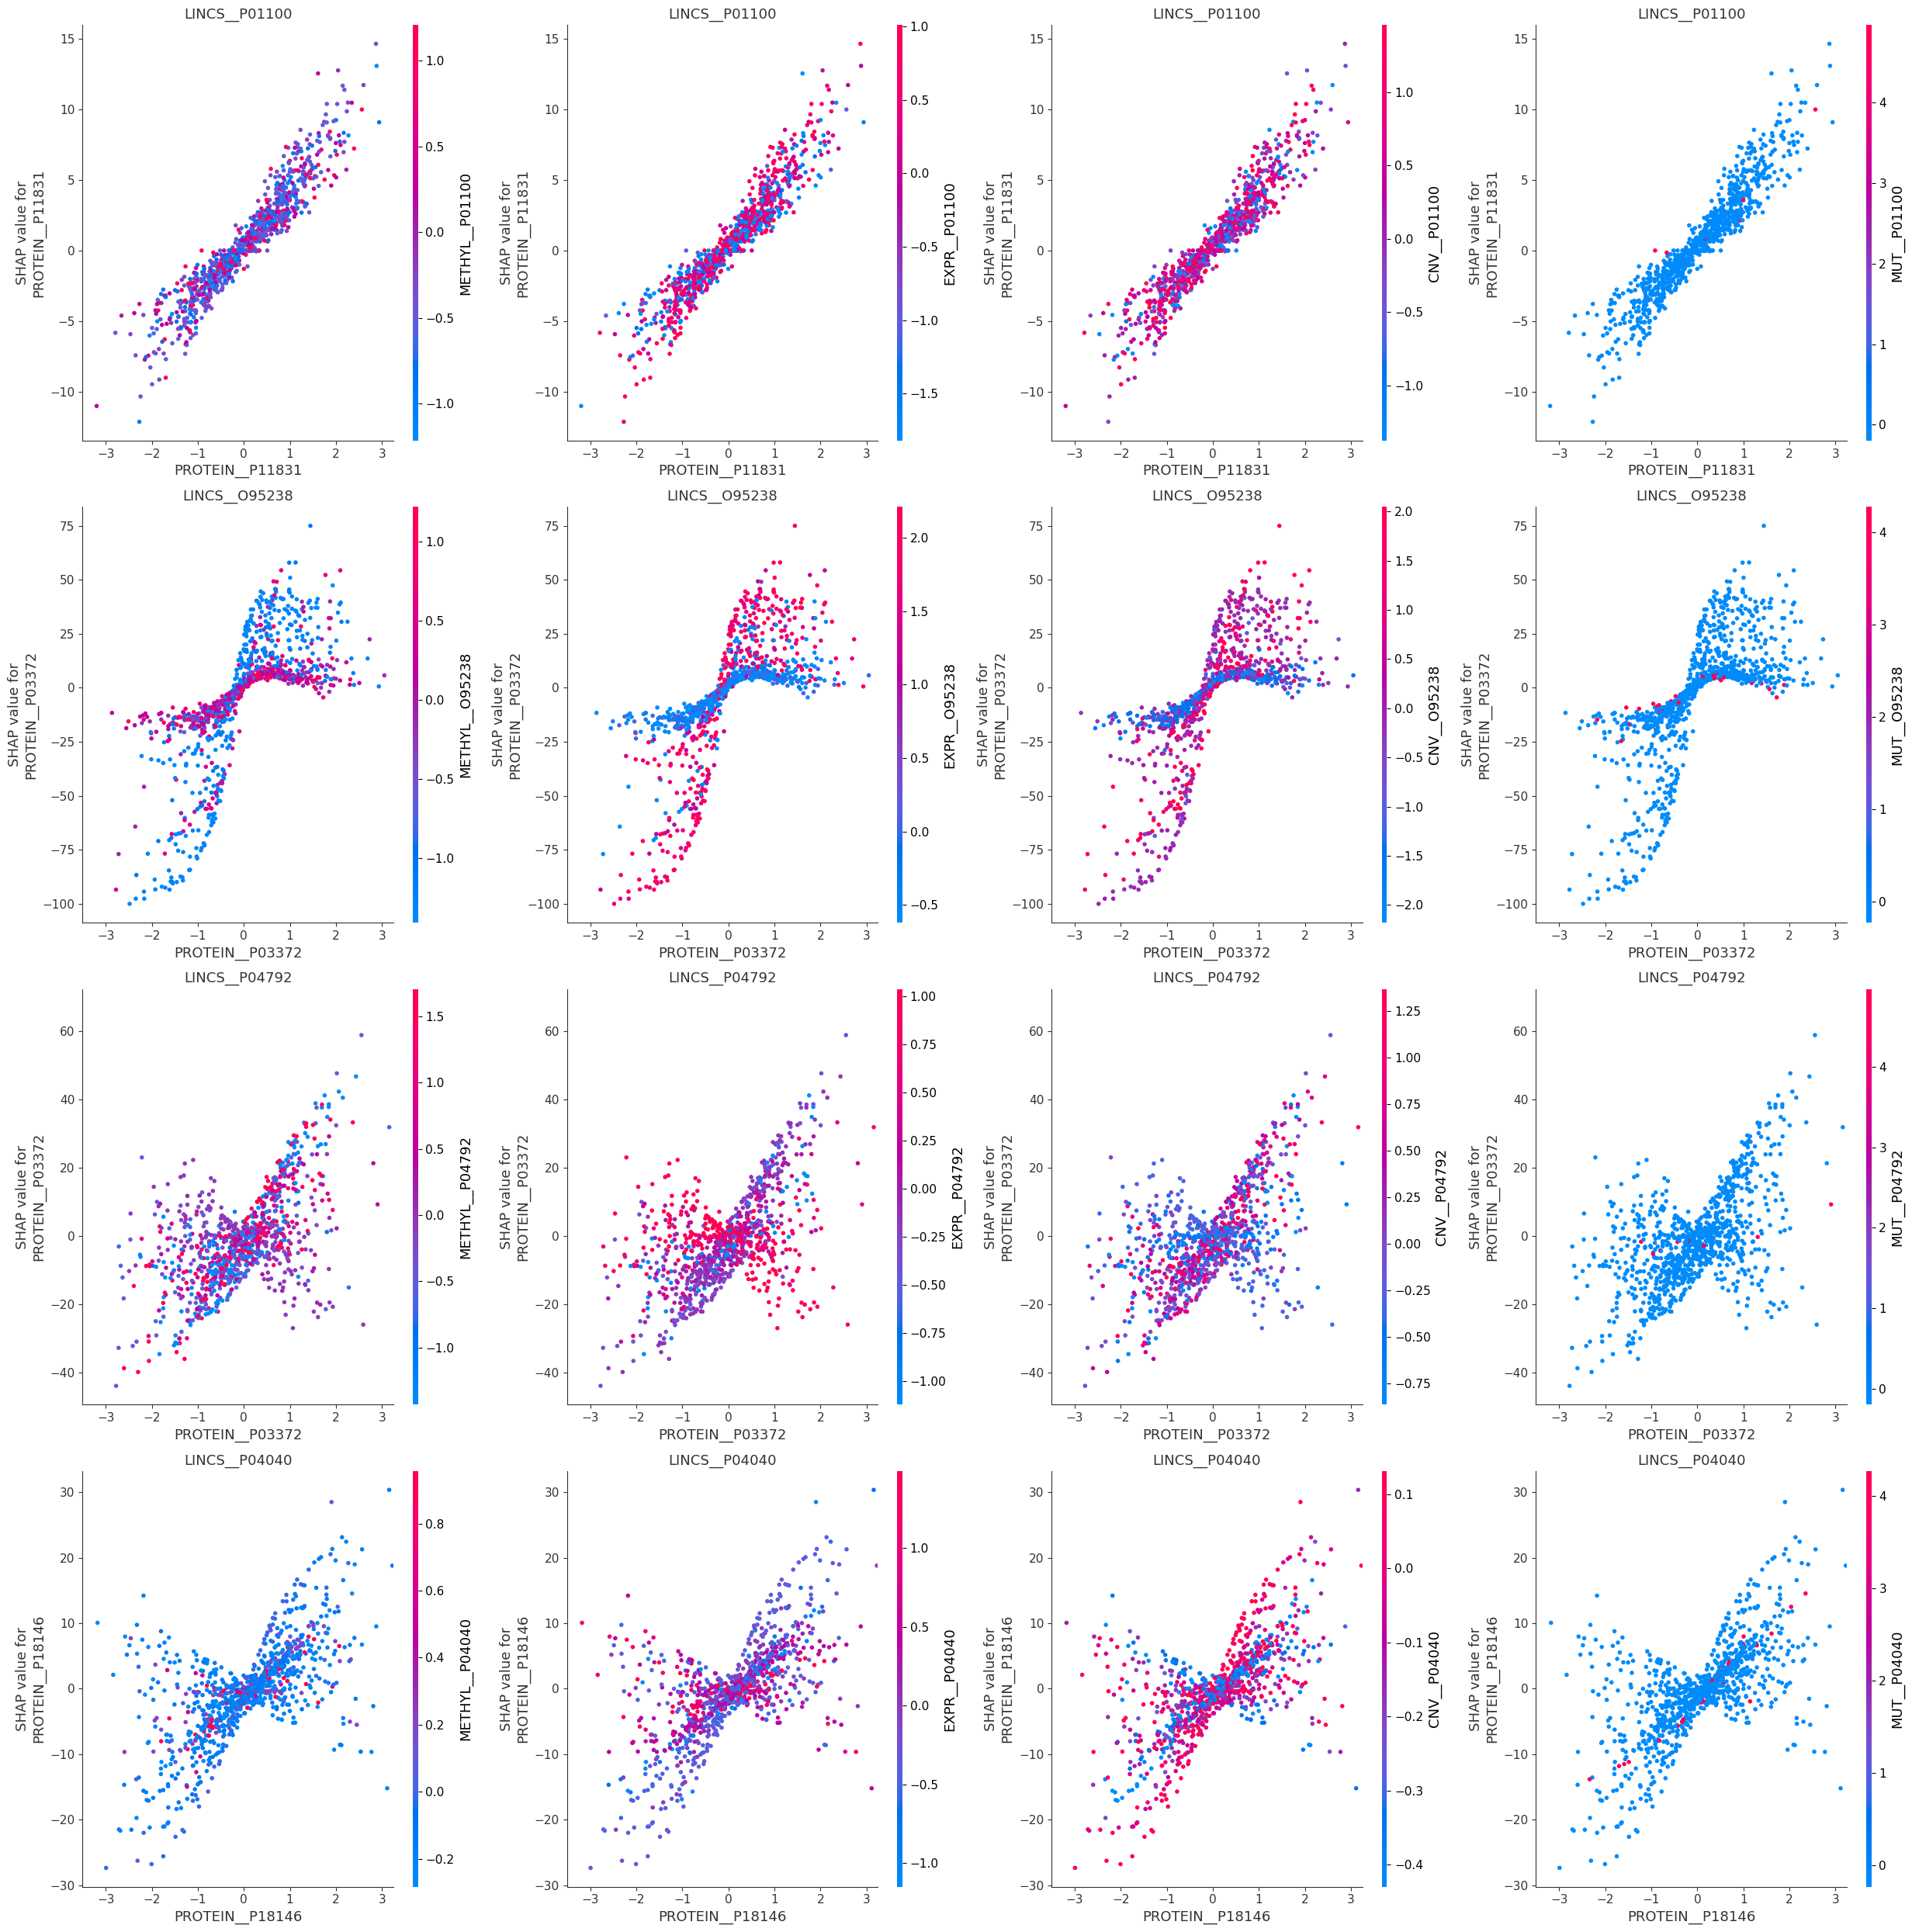

In [365]:
f, axes = plt.subplots(4,4, figsize=(25,25), sharex=True)
idx = 0
i = 0
while i < 4: 

    idx = np.random.randint(100)
    #idx = 19
    lincs_node = [x for x in data.node_names if 'LINCS__' in x][idx]
    uniprot = lincs_node.split('__')[-1]
    rna_node = f'RNA__{uniprot}'
    #print(rna_node)

    #idx = 5
    #uniprot = r_cell_gene_df.uniprot.values[idx]
    #lincs_node = f'LINCS__{uniprot}'
    #rna_node = f'RNA__{uniprot}'

    func, x_func, meta = extract_entity_function(rna_node, model, data, X)


    x_df = pd.DataFrame(x_func.detach(), columns=meta['input_edge_names'])
    prot_inputs = [x for x in meta['input_edge_names'] if 'PROTEIN__' in x]
    x_df[prot_inputs] = np.random.randn(*x_df[prot_inputs].values.shape)
    rna_inputs = [x for x in meta['input_edge_names'] if 'RNA__' in x]
    x_df[rna_inputs] = np.random.randn(*x_df[rna_inputs].values.shape)

    if (len(prot_inputs) == 0): 
        idx += 1
        continue 

    print(meta['input_edge_names'])
    print(rna_node)

    f = lambda X: func(torch.tensor(X, dtype=torch.float32)).detach().numpy()

    test_set = x_df.iloc[100:1100, :]

    explainer = shap.KernelExplainer(f, x_df.iloc[:100,:])

    shap_values = explainer.shap_values(X = test_set, nsamples = 100)

    for j,omic in enumerate(['METHYL', 'EXPR', 'CNV', 'MUT']): 
        omic_node = f'{omic}__{uniprot}' 
        if omic_node in meta['input_edge_names']: 
            #shap.dependence_plot(str(rna_inputs[0]), shap_values[0], test_set, interaction_index=omic_node, title=lincs_node, show=False, ax=axes[i, j])
            shap.dependence_plot(str(prot_inputs[0]), shap_values[0], test_set, interaction_index=omic_node, title=lincs_node, show=False, ax=axes[i, j])

    idx+=1 
    i+=1
    print('####')

plt.tight_layout()
plt.show()

In [332]:
meta['input_edge_names']

array(['RNA__MIMAT0000267', 'RNA__MIMAT0026475', 'RNA__MIMAT0000421',
       'EXPR__P18031', 'METHYL__P18031', 'CNV__P18031', 'MUT__P18031'],
      dtype='<U19')

In [333]:
x_df = pd.DataFrame(x_func.detach(), columns=meta['input_edge_names'])
prot_inputs = [x for x in meta['input_edge_names'] if 'PROTEIN__' in x]
x_df[prot_inputs] = np.random.randn(*x_df[prot_inputs].values.shape)
rna_inputs = [x for x in meta['input_edge_names'] if 'RNA__' in x]
x_df[rna_inputs] = np.random.randn(*x_df[rna_inputs].values.shape)


f = lambda X: func(torch.tensor(X, dtype=torch.float32)).detach().numpy()

x_df.head()

RNA__MIMAT0000267  RNA__MIMAT0026475  RNA__MIMAT0000421  EXPR__P18031  \
0          -0.466664           0.990627           0.197390      0.630110   
1           1.279034          -2.032162           0.562601      0.075108   
2           0.335189           0.218193          -0.437623      0.630110   
3          -1.326189          -1.205394          -0.877613      1.704313   
4           0.102812           1.639160           0.440057     -0.619749   

   METHYL__P18031  CNV__P18031  MUT__P18031  
0       -0.709689    -0.317898       -0.231  
1       -1.065401     0.755747       -0.231  
2       -0.709689    -0.317898       -0.231  
3        0.492954     3.662258       -0.231  
4       -0.211963     1.052276       -0.231

In [334]:
test_set = x_df.iloc[100:700, :]

explainer = shap.KernelExplainer(f, x_df.iloc[:100,:])

shap_values = explainer.shap_values(X = test_set, nsamples = 100)

  0%|          | 0/600 [00:00<?, ?it/s]

100%|██████████| 600/600 [00:22<00:00, 26.67it/s]


In [336]:
meta['output_edge_names']

array(['LINCS__P18031', 'PROTEIN__P18031'], dtype='<U19')

LINCS__P18031


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


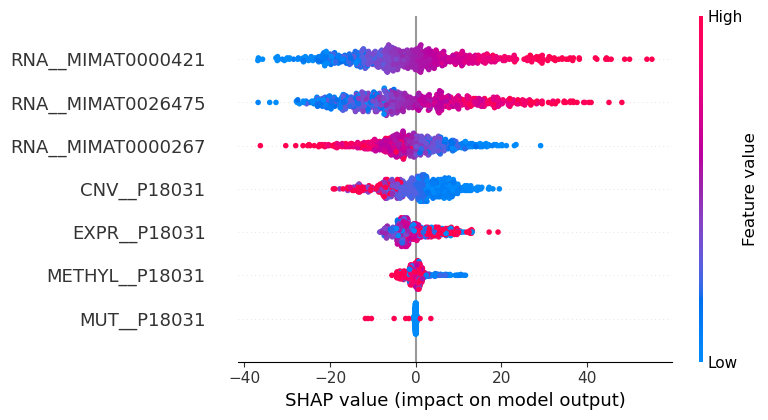

In [337]:
feat_idx = 0
name = meta['output_edge_names'][feat_idx]
print(name)

shap.summary_plot(shap_values = shap_values[feat_idx],
                  features = test_set
                  )


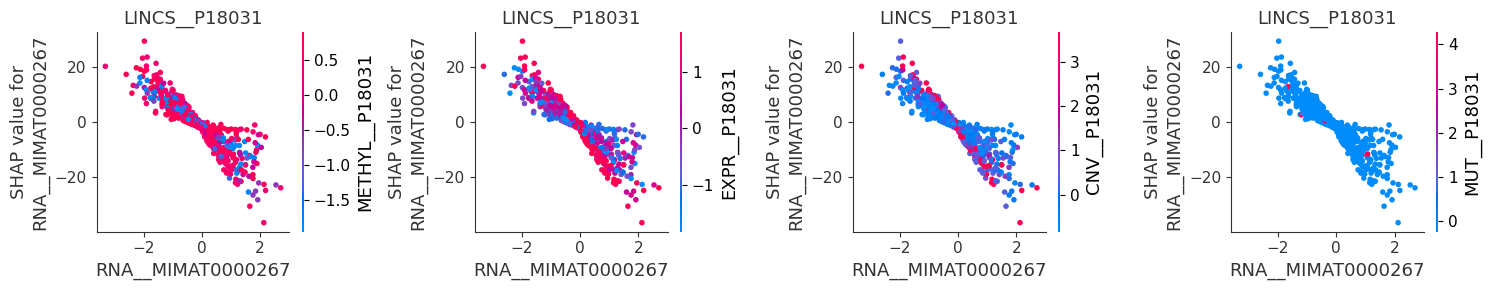

In [348]:
f, axes = plt.subplots(1,4, figsize=(15,3), sharex=True)

for omic, ax in zip(['METHYL', 'EXPR', 'CNV', 'MUT'], axes.flat): 
    omic_node = f'{omic}__{uniprot}' 
    if omic_node in meta['input_edge_names']: 
        shap.dependence_plot(str(rna_inputs[0]), shap_values[0], test_set, interaction_index=omic_node, title=lincs_node, show=False, ax=ax)
        #shap.dependence_plot(str(prot_inputs[0]), shap_values[0], test_set, interaction_index=omic_node, title=lincs_node)
    
plt.tight_layout()
plt.show()

In [ ]:
# EGFR ~ PROTEIN__P00533
# HER2 (ERBB2) ~ P04626

In [493]:
model.norms[0]

BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [589]:
func, ex_smol, meta = extract_entity_function('PROTEIN__P04626', model, data, X)
func

dense_func_node(
  (lin1): Linear(in_features=82, out_features=5, bias=True)
  (lin2): Linear(in_features=5, out_features=5, bias=True)
  (lin3): Linear(in_features=5, out_features=41, bias=True)
  (nonlin): ELU(alpha=1.0)
)

In [618]:
#out = func(ex_smol)
#f = lambda X: np.abs(((func(torch.tensor(X)) - out.mean(dim=0))/out.std(dim=0)).detach().numpy())
#f = lambda X: (model.eval().norms[0](func(torch.tensor(X)).view(-1,1)).view(X.shape[0], -1).detach().numpy())
f = lambda X: func(torch.tensor(X, dtype=torch.float)).detach().numpy()
ex_smol_df = pd.DataFrame(ex_smol.detach().numpy(), columns=meta['input_edge_names'])

In [619]:
drugs = [x for x in meta['input_edge_names'] if 'DRUG__' in x]

In [620]:
no_drug_df = ex_smol_df.copy()
no_drug_df[drugs] = np.zeros(no_drug_df[drugs].values.shape)

In [621]:
no_drug_out = f(no_drug_df.values)

In [622]:
no_drug_out

array([[ 1.3916585 , -5.19966   ,  0.29090565, ..., -0.64563644,
        -5.01514   , -1.2669067 ],
       [ 1.0490413 , -5.484312  ,  0.04935068, ..., -0.9221911 ,
        -5.2578025 , -1.1730375 ],
       [ 1.3916585 , -5.19966   ,  0.29090565, ..., -0.64563644,
        -5.01514   , -1.2669067 ],
       ...,
       [ 1.3916585 , -5.19966   ,  0.29090565, ..., -0.64563644,
        -5.01514   , -1.2669067 ],
       [ 0.8196788 , -5.675343  , -0.10580814, ..., -1.1138673 ,
        -5.4181294 , -1.1082742 ],
       [ 0.7836801 , -5.6060243 , -0.5367879 , ..., -0.65846854,
        -5.5384817 , -1.2342396 ]], dtype=float32)

In [606]:
drug_ = drugs[4]

In [623]:
nbackground = 100
nsamples = 250
drug_set = ex_smol_df#[lambda x: x[drug_] > 0].reset_index(drop=True)
back_set = drug_set.iloc[:nbackground, :]
test_set = drug_set.iloc[nbackground:int(nbackground + nsamples),:]

explainer = shap.KernelExplainer(f, back_set)

shap_values = explainer.shap_values(X = test_set, nsamples = 500)

  0%|          | 0/250 [00:00<?, ?it/s]

100%|██████████| 250/250 [01:17<00:00,  3.21it/s]


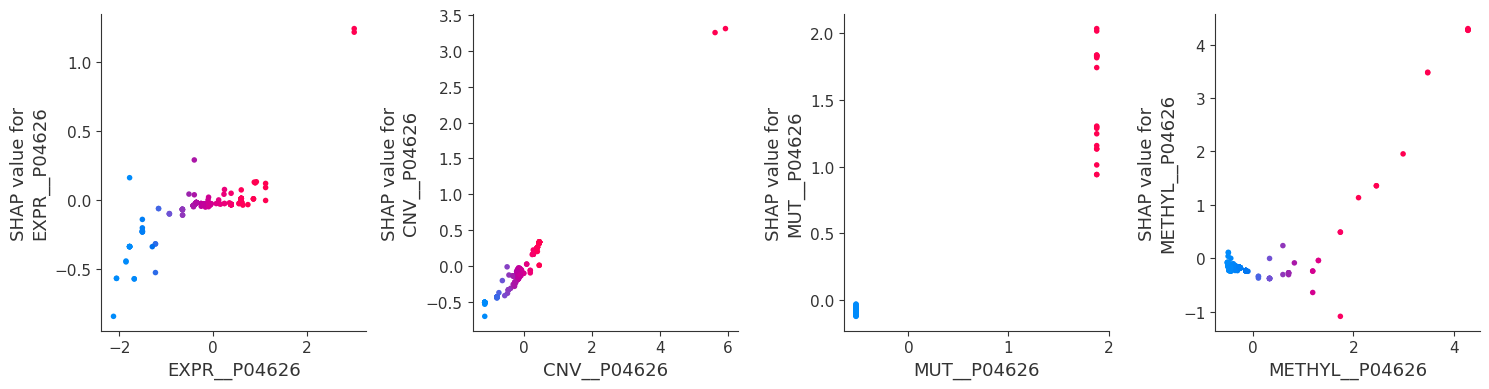

In [624]:
fig,axes = plt.subplots(1,4, figsize=(15, 4))
for omic, ax in zip(['EXPR', 'CNV', 'MUT', 'METHYL'], axes.flat): 
    #shap.dependence_plot(str(drug_), np.stack(shap_values).mean(axis=0), test_set, interaction_index=f'{omic}__P04626', ax=ax, show=False)
    #shap.dependence_plot(str(drug_), shap_values[8], test_set, interaction_index=f'{omic}__P04626', ax=ax, show=False)
    shap.dependence_plot(f'{omic}__P04626', shap_values[0], test_set, interaction_index=f'{omic}__P04626', ax=ax, show=False)
plt.tight_layout()
plt.show()

In [ ]:
# f'{omic}__P04626'

In [386]:
druginfo = pd.read_csv('../../data/compoundinfo_beta.txt', sep='\t')
druginfo[lambda x: x.pert_id == drug_.split('__')[-1]]

pert_id cmap_name target             moa  \
32249  BRD-K66175015  afatinib   EGFR  EGFR inhibitor   
32250  BRD-K66175015  afatinib  ERBB2  EGFR inhibitor   
32251  BRD-K66175015  afatinib  ERBB4  EGFR inhibitor   

                                        canonical_smiles  \
32249  CN(C)CC=CC(=O)Nc1cc2c(Nc3ccc(F)c(Cl)c3)ncnc2cc...   
32250  CN(C)CC=CC(=O)Nc1cc2c(Nc3ccc(F)c(Cl)c3)ncnc2cc...   
32251  CN(C)CC=CC(=O)Nc1cc2c(Nc3ccc(F)c(Cl)c3)ncnc2cc...   

                         inchi_key compound_aliases  
32249  ULXXDDBFHOBEHA-CWDCEQMOSA-N              NaN  
32250  ULXXDDBFHOBEHA-CWDCEQMOSA-N              NaN  
32251  ULXXDDBFHOBEHA-CWDCEQMOSA-N              NaN

In [553]:
druginfo[lambda x: x.cmap_name == 'afatinib']

pert_id cmap_name target             moa  \
32249  BRD-K66175015  afatinib   EGFR  EGFR inhibitor   
32250  BRD-K66175015  afatinib  ERBB2  EGFR inhibitor   
32251  BRD-K66175015  afatinib  ERBB4  EGFR inhibitor   
32252  BRD-A58767537  afatinib   EGFR  EGFR inhibitor   
32253  BRD-A58767537  afatinib  ERBB2  EGFR inhibitor   
32254  BRD-A58767537  afatinib  ERBB4  EGFR inhibitor   

                                        canonical_smiles  \
32249  CN(C)CC=CC(=O)Nc1cc2c(Nc3ccc(F)c(Cl)c3)ncnc2cc...   
32250  CN(C)CC=CC(=O)Nc1cc2c(Nc3ccc(F)c(Cl)c3)ncnc2cc...   
32251  CN(C)CC=CC(=O)Nc1cc2c(Nc3ccc(F)c(Cl)c3)ncnc2cc...   
32252  CN(C)CC=CC(=O)Nc1cc2c(Nc3ccc(F)c(Cl)c3)ncnc2cc...   
32253  CN(C)CC=CC(=O)Nc1cc2c(Nc3ccc(F)c(Cl)c3)ncnc2cc...   
32254  CN(C)CC=CC(=O)Nc1cc2c(Nc3ccc(F)c(Cl)c3)ncnc2cc...   

                         inchi_key compound_aliases  
32249  ULXXDDBFHOBEHA-CWDCEQMOSA-N              NaN  
32250  ULXXDDBFHOBEHA-CWDCEQMOSA-N              NaN  
32251  ULXXDDBFHOBEHA-CWDCEQMOSA-N              NaN  
32252  ULXXDDBFHOBEHA-ONEGZZNKSA-N              NaN  
32253  ULXXDDBFHOBEHA-ONEGZZNKSA-N              NaN  
32254  ULXXDDBFHOBEHA-ONEGZZNKSA-N              NaN

In [554]:
targetome = pd.read_csv('../../data/targetome.txt', sep='\t')
targetome[lambda x: (x.Target_Name == 'EGFR') & (x.Assay_Relation == '=')].Drug.unique()

array(['Lapatinib Ditosylate', 'Erlotinib Hydrochloride', 'Cetuximab',
       'Vandetanib', 'Crizotinib', 'Docetaxel', 'Bosutinib',
       'Imatinib Mesylate', 'Afatinib Dimaleate', 'Osimertinib',
       'Ibrutinib', 'Axitinib', 'Necitumumab', 'Dasatinib', 'Gefitinib',
       'Sunitinib Malate', 'Panitumumab'], dtype=object)

In [555]:
gefitinib = targetome[lambda x: (x.Drug == 'Afatinib Dimaleate') & (x.Target_Name == 'EGFR') & (x.Assay_Relation == '=')]
gefitinib

Drug Target_Name Target_Type Target_UniProt  \
7637  Afatinib Dimaleate        EGFR     Protein         P00533   
7638  Afatinib Dimaleate        EGFR     Protein         P00533   
7639  Afatinib Dimaleate        EGFR     Protein         P00533   
7640  Afatinib Dimaleate        EGFR     Protein         P00533   
7641  Afatinib Dimaleate        EGFR     Protein         P00533   
7642  Afatinib Dimaleate        EGFR     Protein         P00533   
7643  Afatinib Dimaleate        EGFR     Protein         P00533   
7644  Afatinib Dimaleate        EGFR     Protein         P00533   
7645  Afatinib Dimaleate        EGFR     Protein         P00533   
7646  Afatinib Dimaleate        EGFR     Protein         P00533   
7647  Afatinib Dimaleate        EGFR     Protein         P00533   
7648  Afatinib Dimaleate        EGFR     Protein         P00533   
7649  Afatinib Dimaleate        EGFR     Protein         P00533   
7650  Afatinib Dimaleate        EGFR     Protein         P00533   
7651  Afatinib Dimaleate        EGFR     Protein         P00533   
7652  Afatinib Dimaleate        EGFR     Protein         P00533   
7653  Afatinib Dimaleate        EGFR     Protein         P00533   
7654  Afatinib Dimaleate        EGFR     Protein         P00533   
7655  Afatinib Dimaleate        EGFR     Protein         P00533   
7656  Afatinib Dimaleate        EGFR     Protein         P00533   
7657  Afatinib Dimaleate        EGFR     Protein         P00533   

     Target_Species   Database Reference Assay_Type Assay_Relation  \
7637   Homo sapiens  BindingDB  20550212       IC50              =   
7638   Homo sapiens  BindingDB  24183742       IC50              =   
7639   Homo sapiens  BindingDB  22037378         KD              =   
7640   Homo sapiens  BindingDB  22037378         KD              =   
7641   Homo sapiens  BindingDB  25409491       IC50              =   
7642   Homo sapiens  BindingDB  22037378         KD              =   
7643   Homo sapiens  BindingDB  22037378         KD              =   
7644   Homo sapiens  BindingDB  22037378         KD              =   
7645   Homo sapiens  BindingDB  22037378         KD              =   
7646   Homo sapiens  BindingDB  22037378         KD              =   
7647   Homo sapiens  BindingDB  25409491       IC50              =   
7648   Homo sapiens     IUPHAR  22037378         Kd              =   
7649   Homo sapiens  BindingDB  22621397       IC50              =   
7650   Homo sapiens  BindingDB  22037378         KD              =   
7651   Homo sapiens  BindingDB  22037378         KD              =   
7652   Homo sapiens  BindingDB  22037378         KD              =   
7653   Homo sapiens  BindingDB  22037378         KD              =   
7654   Homo sapiens  BindingDB  22037378         KD              =   
7655   Homo sapiens  BindingDB  24565969       IC50              =   
7656   Homo sapiens     IUPHAR  20550212       IC50              =   
7657   Homo sapiens     IUPHAR  18408761       IC50              =   

      Assay_Value EvidenceLevel_Assigned  
7637        11.00                    III  
7638         0.19                    III  
7639         0.25                    III  
7640         0.14                    III  
7641         0.50                    III  
7642         0.19                    III  
7643         0.61                    III  
7644         0.20                    III  
7645         0.10                    III  
7646         0.23                    III  
7647         0.97                    III  
7648         0.25                    III  
7649         0.50                    III  
7650         1.10                    III  
7651         0.11                    III  
7652         0.12                    III  
7653         0.14                    III  
7654         0.12                    III  
7655         1.00                    III  
7656          NaN                    III  
7657          NaN                    III

PROTEIN__P52735


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


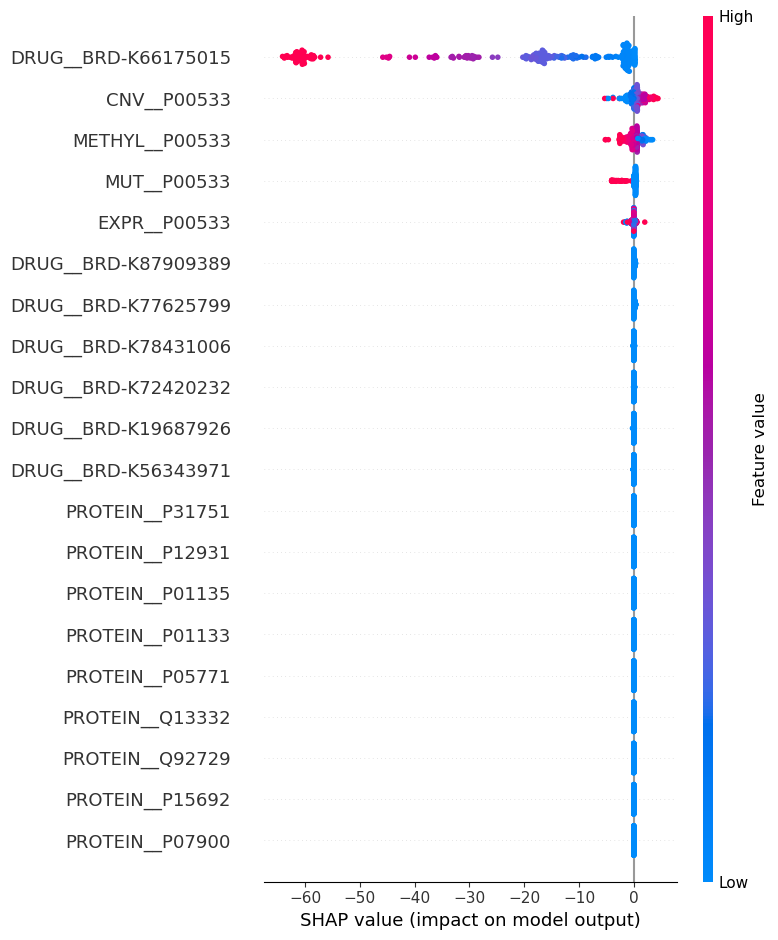

In [556]:
feat_idx = 2
name = out_edge_names[feat_idx]
print(name)

shap.summary_plot(shap_values = shap_values[feat_idx],
                  features = test_set
                  )


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


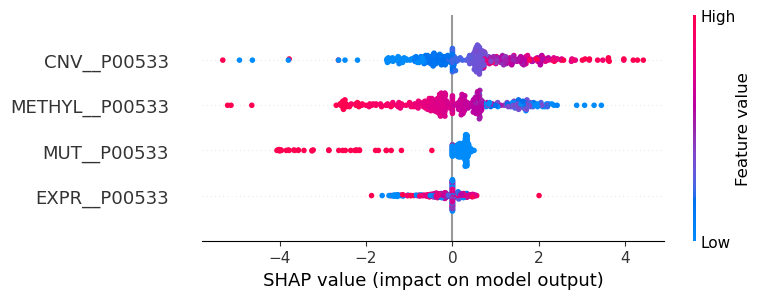

In [557]:
shap.summary_plot(shap_values = shap_values[feat_idx][:, [i for i,x in enumerate(test_set.columns) if x in ['EXPR__P00533', 'METHYL__P00533', 'CNV__P00533', 'MUT__P00533']]],
                  features = test_set[[x for i,x in enumerate(test_set.columns) if x in ['EXPR__P00533', 'METHYL__P00533', 'CNV__P00533', 'MUT__P00533']]]
                  )



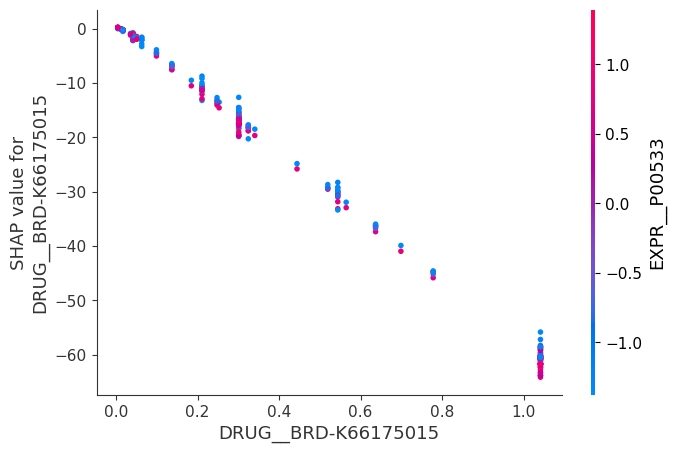

In [558]:
shap.dependence_plot(drug_, shap_values[feat_idx], test_set, interaction_index='EXPR__P00533')

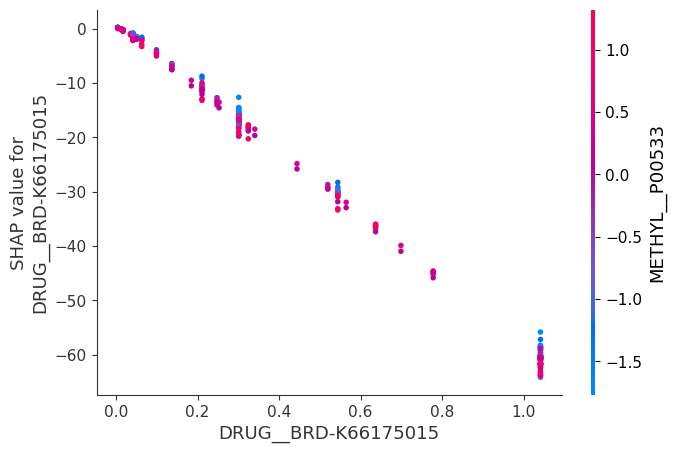

In [559]:
shap.dependence_plot(drug_, shap_values[feat_idx], test_set, interaction_index='METHYL__P00533')

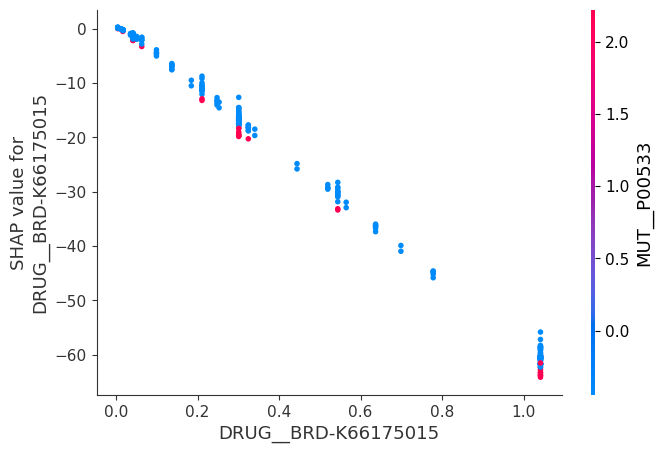

In [560]:
shap.dependence_plot(drug_, shap_values[feat_idx], test_set, interaction_index='MUT__P00533')

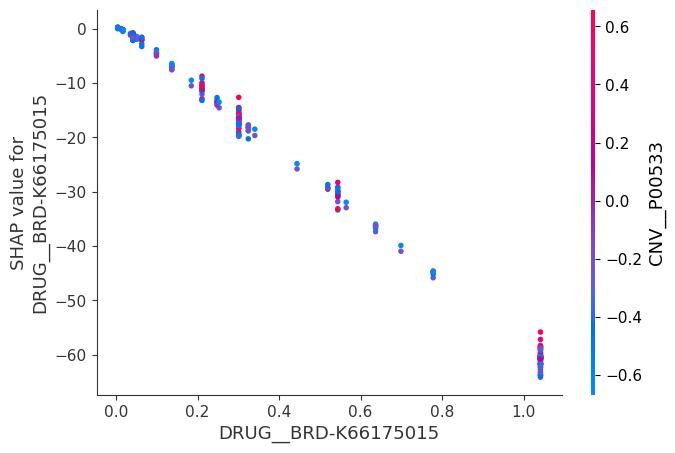

In [561]:
shap.dependence_plot(drug_, shap_values[feat_idx], test_set, interaction_index='CNV__P00533')

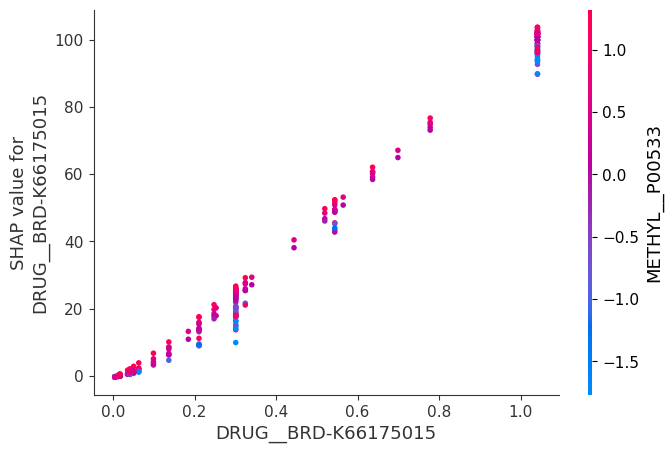

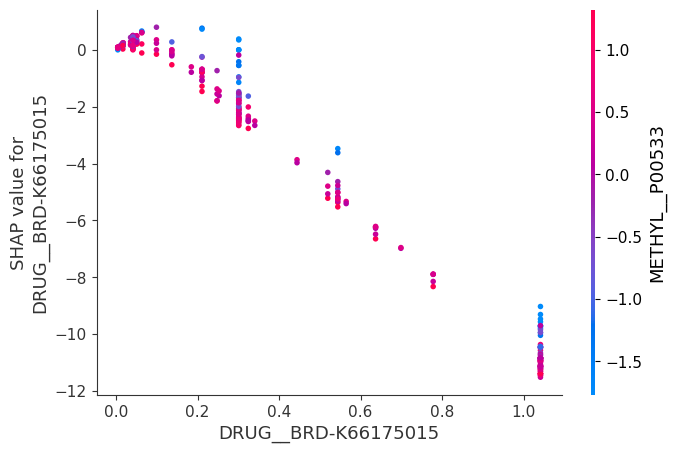

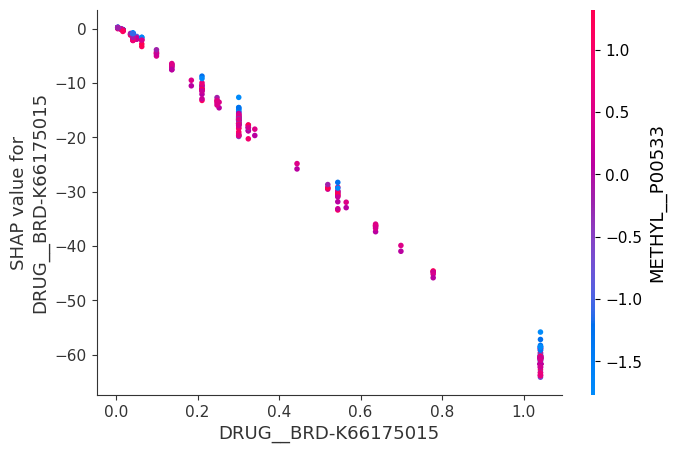

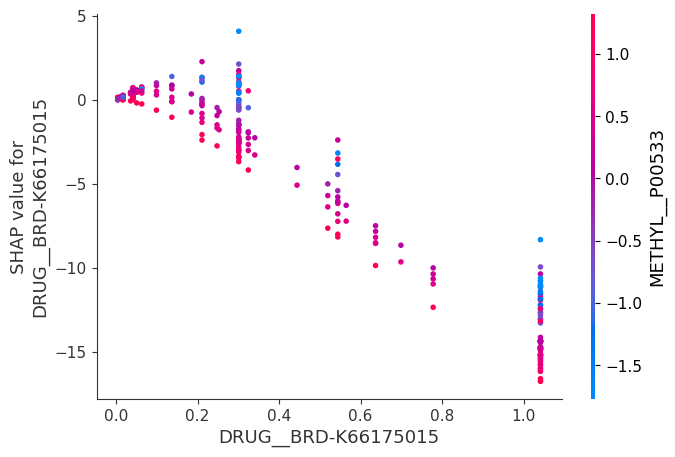

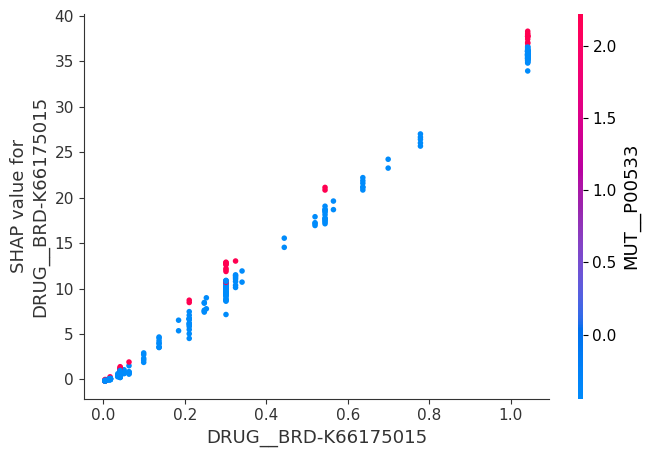

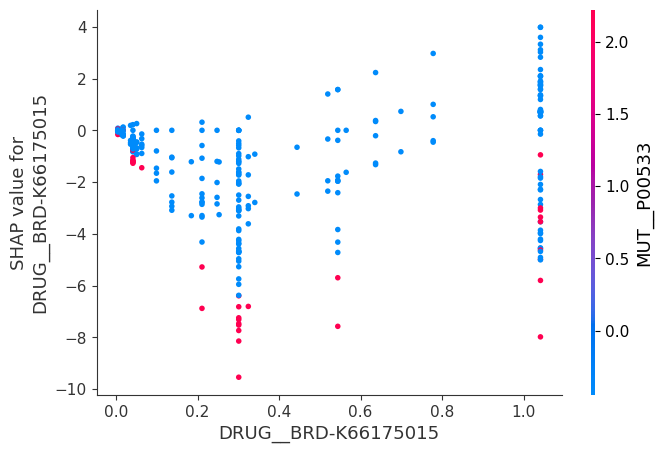

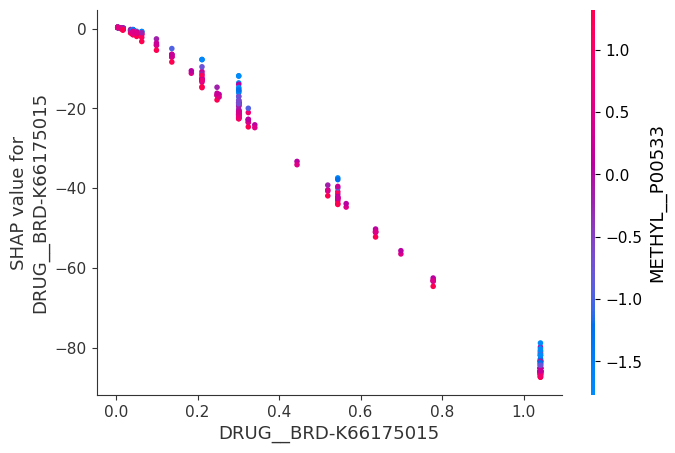

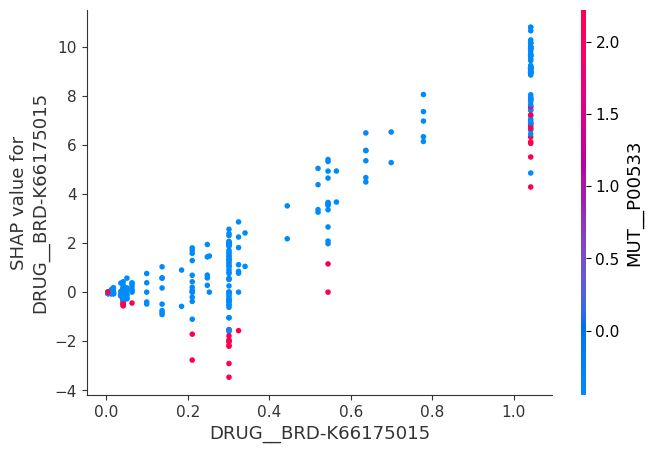

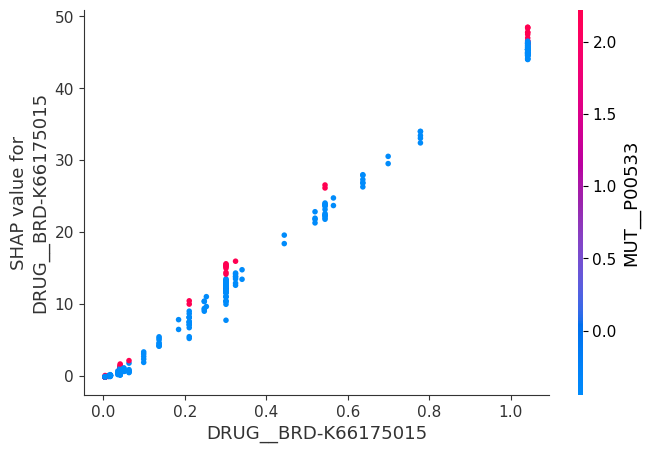

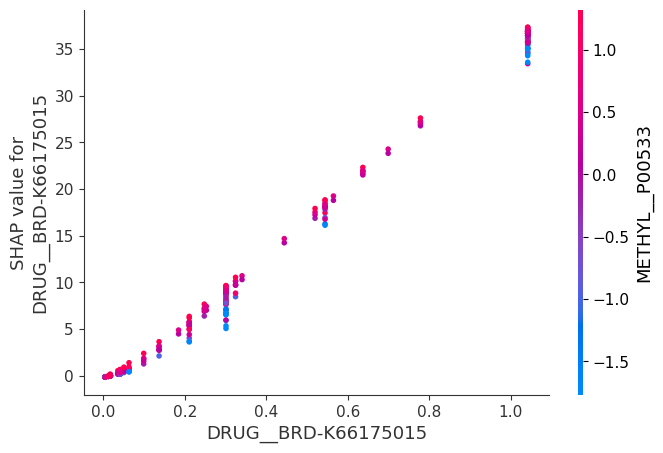

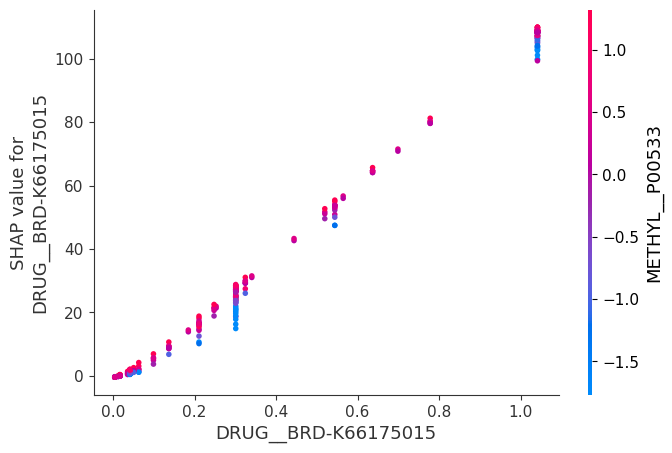

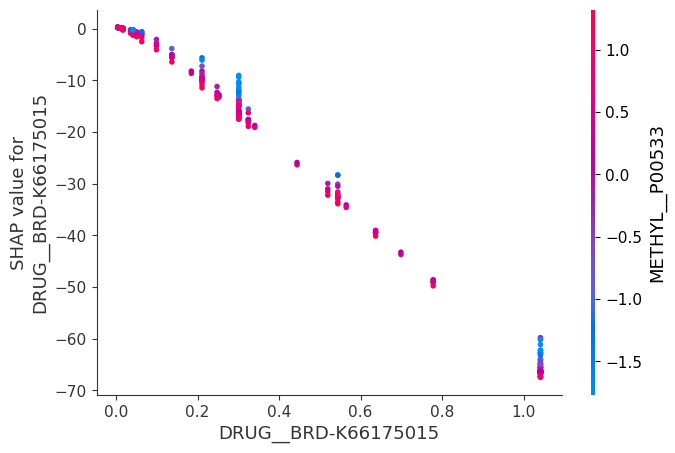

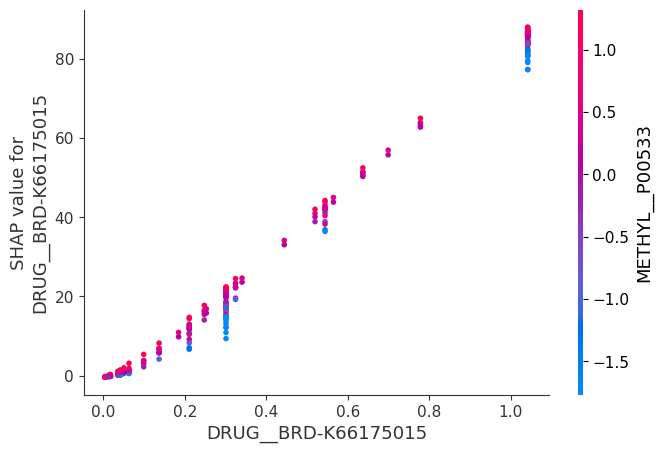

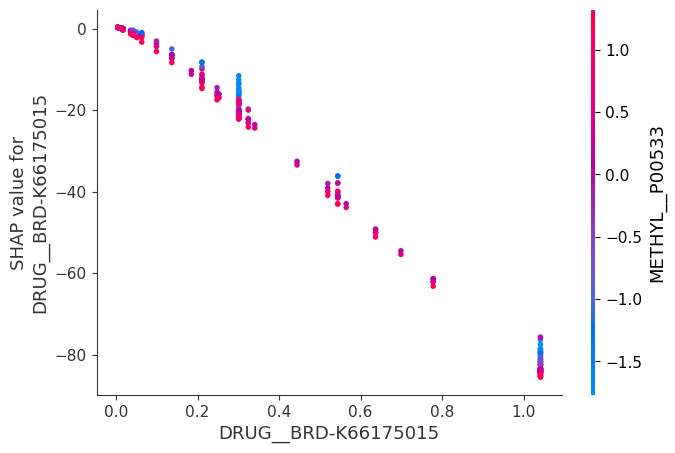

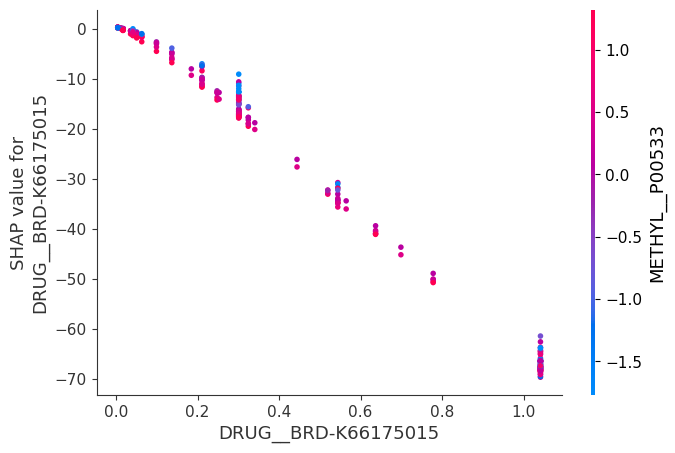

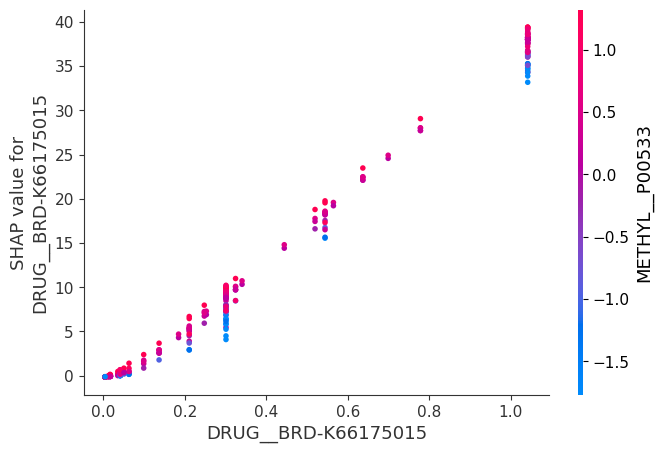

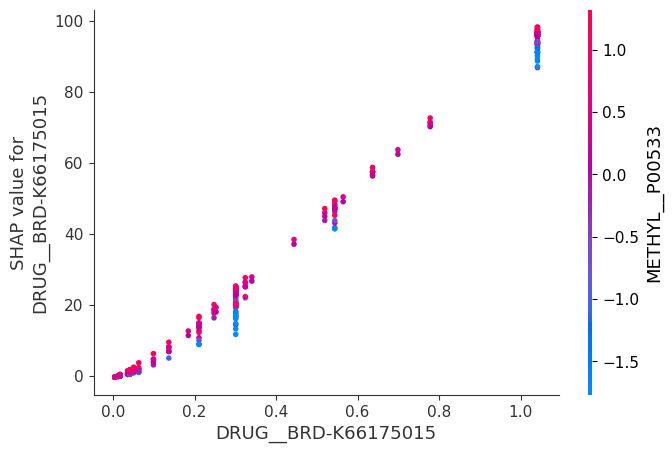

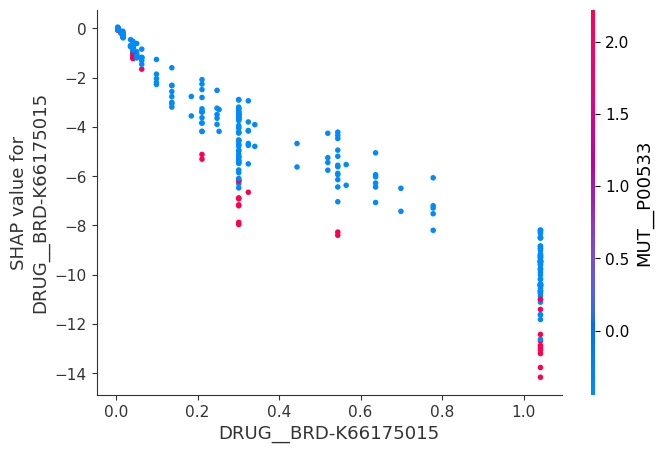

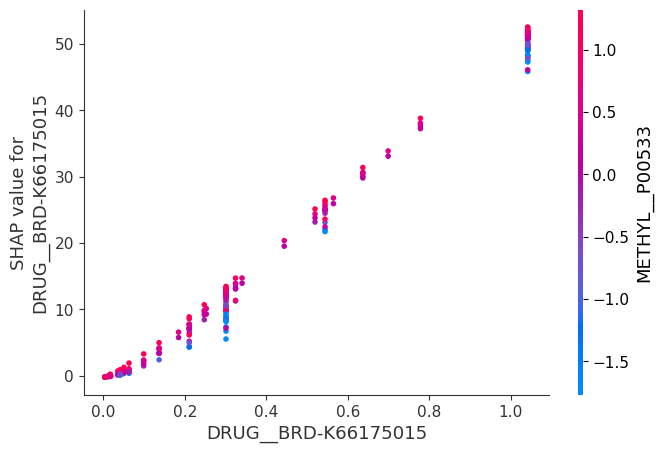

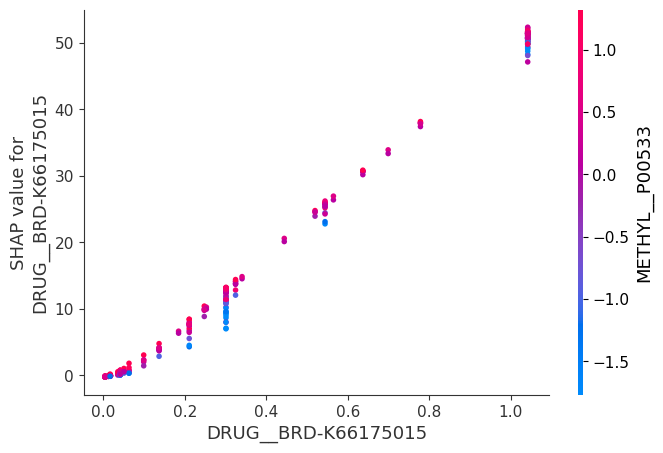

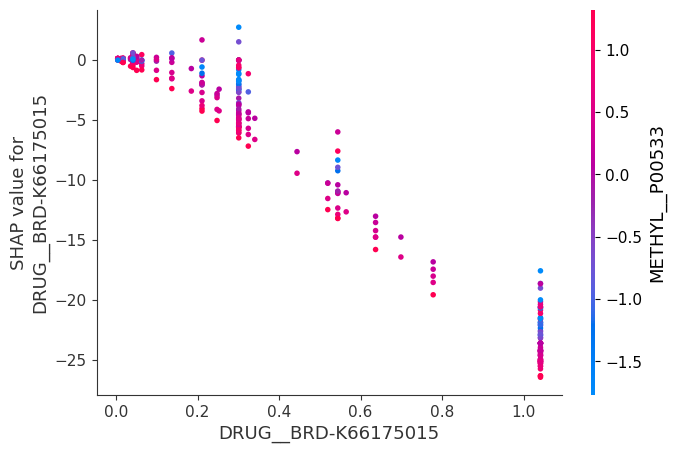

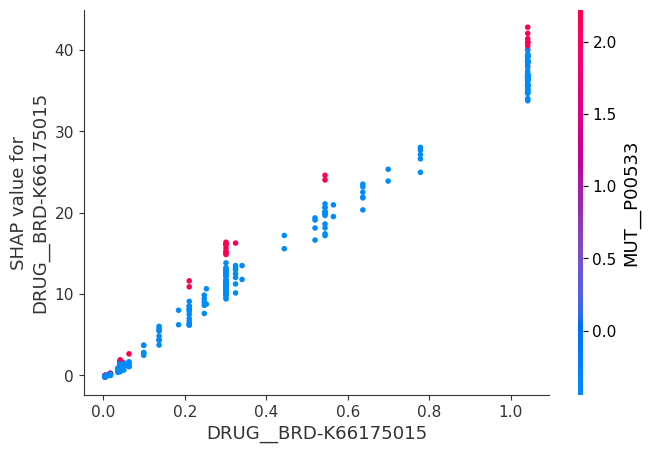

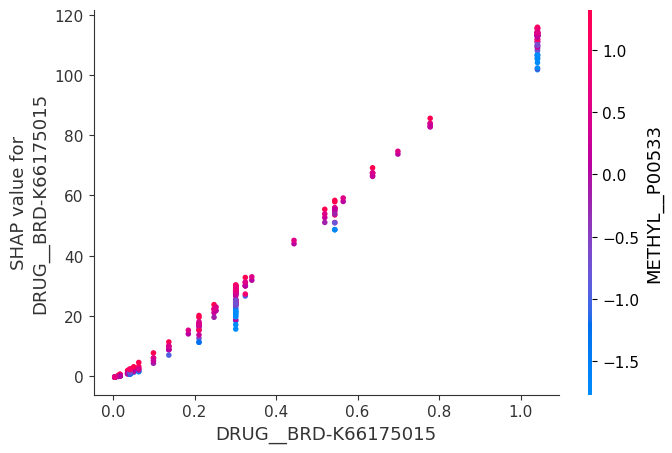

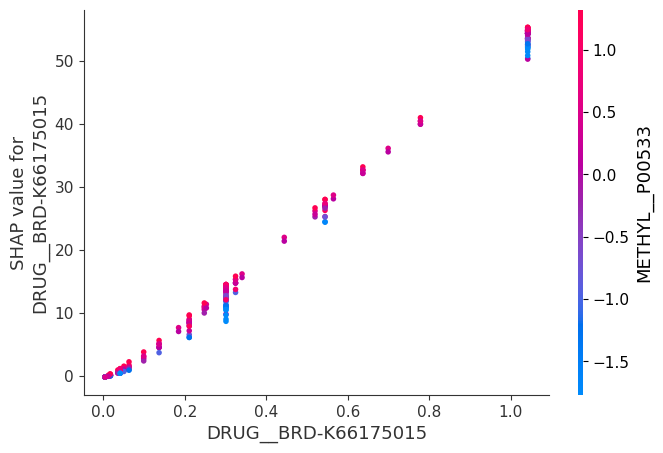

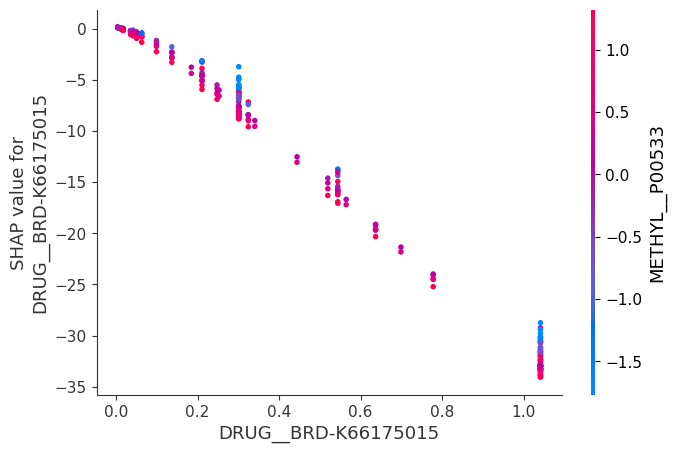

In [562]:
for i in range(25): 
    shap.dependence_plot(drug_, shap_values[i], test_set)

In [571]:
10**(0.6) - 1

2.9810717055349722

In [15]:
druginfo.loc["BRD-K29905972"]

cmap_name target              moa  \
pert_id                                           
BRD-K29905972  axitinib   FLT1  PDGFR inhibitor   
BRD-K29905972  axitinib   FLT4  PDGFR inhibitor   
BRD-K29905972  axitinib    KDR  PDGFR inhibitor   
BRD-K29905972  axitinib   FLT1  VEGFR inhibitor   
BRD-K29905972  axitinib   FLT4  VEGFR inhibitor   
BRD-K29905972  axitinib    KDR  VEGFR inhibitor   

                                            canonical_smiles  \
pert_id                                                        
BRD-K29905972  CNC(=O)c1ccccc1Sc1ccc2c(C=Cc3ccccn3)n[nH]c2c1   
BRD-K29905972  CNC(=O)c1ccccc1Sc1ccc2c(C=Cc3ccccn3)n[nH]c2c1   
BRD-K29905972  CNC(=O)c1ccccc1Sc1ccc2c(C=Cc3ccccn3)n[nH]c2c1   
BRD-K29905972  CNC(=O)c1ccccc1Sc1ccc2c(C=Cc3ccccn3)n[nH]c2c1   
BRD-K29905972  CNC(=O)c1ccccc1Sc1ccc2c(C=Cc3ccccn3)n[nH]c2c1   
BRD-K29905972  CNC(=O)c1ccccc1Sc1ccc2c(C=Cc3ccccn3)n[nH]c2c1   

                                 inchi_key compound_aliases  
pert_id                                                      
BRD-K29905972  RITAVMQDGBJQJZ-FMIVXFBMSA-N              NaN  
BRD-K29905972  RITAVMQDGBJQJZ-FMIVXFBMSA-N              NaN  
BRD-K29905972  RITAVMQDGBJQJZ-FMIVXFBMSA-N              NaN  
BRD-K29905972  RITAVMQDGBJQJZ-FMIVXFBMSA-N              NaN  
BRD-K29905972  RITAVMQDGBJQJZ-FMIVXFBMSA-N              NaN  
BRD-K29905972  RITAVMQDGBJQJZ-FMIVXFBMSA-N              NaN

In [16]:
druginfo.loc["BRD-K50168500"]

cmap_name target             moa  \
pert_id                                            
BRD-K50168500  canertinib   EGFR  EGFR inhibitor   
BRD-K50168500  canertinib  ERBB2  EGFR inhibitor   
BRD-K50168500  canertinib  ERBB4  EGFR inhibitor   

                                                canonical_smiles  \
pert_id                                                            
BRD-K50168500  Fc1ccc(Nc2ncnc3cc(OCCCN4CCOCC4)c(NC(=O)C=C)cc2...   
BRD-K50168500  Fc1ccc(Nc2ncnc3cc(OCCCN4CCOCC4)c(NC(=O)C=C)cc2...   
BRD-K50168500  Fc1ccc(Nc2ncnc3cc(OCCCN4CCOCC4)c(NC(=O)C=C)cc2...   

                                 inchi_key compound_aliases  
pert_id                                                      
BRD-K50168500  OMZCMEYTWSXEPZ-UHFFFAOYSA-N              NaN  
BRD-K50168500  OMZCMEYTWSXEPZ-UHFFFAOYSA-N              NaN  
BRD-K50168500  OMZCMEYTWSXEPZ-UHFFFAOYSA-N              NaN

In [17]:
druginfo.loc["BRD-K66175015"]

cmap_name target             moa  \
pert_id                                          
BRD-K66175015  afatinib   EGFR  EGFR inhibitor   
BRD-K66175015  afatinib  ERBB2  EGFR inhibitor   
BRD-K66175015  afatinib  ERBB4  EGFR inhibitor   

                                                canonical_smiles  \
pert_id                                                            
BRD-K66175015  CN(C)CC=CC(=O)Nc1cc2c(Nc3ccc(F)c(Cl)c3)ncnc2cc...   
BRD-K66175015  CN(C)CC=CC(=O)Nc1cc2c(Nc3ccc(F)c(Cl)c3)ncnc2cc...   
BRD-K66175015  CN(C)CC=CC(=O)Nc1cc2c(Nc3ccc(F)c(Cl)c3)ncnc2cc...   

                                 inchi_key compound_aliases  
pert_id                                                      
BRD-K66175015  ULXXDDBFHOBEHA-CWDCEQMOSA-N              NaN  
BRD-K66175015  ULXXDDBFHOBEHA-CWDCEQMOSA-N              NaN  
BRD-K66175015  ULXXDDBFHOBEHA-CWDCEQMOSA-N              NaN

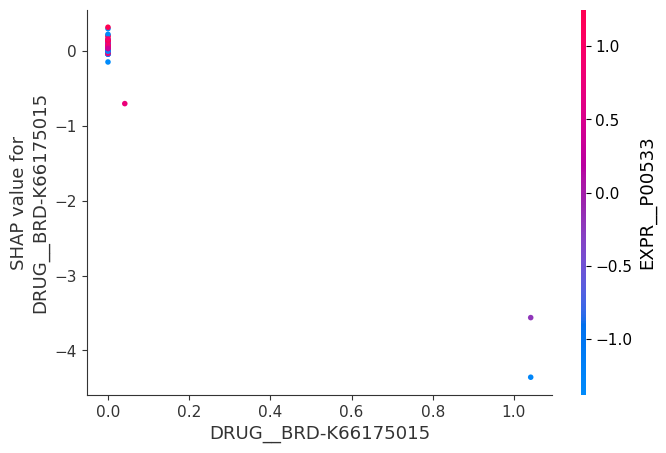

In [448]:
shap.dependence_plot("DRUG__BRD-K66175015", shap_values[feat_idx], test_set, interaction_index='EXPR__P00533')

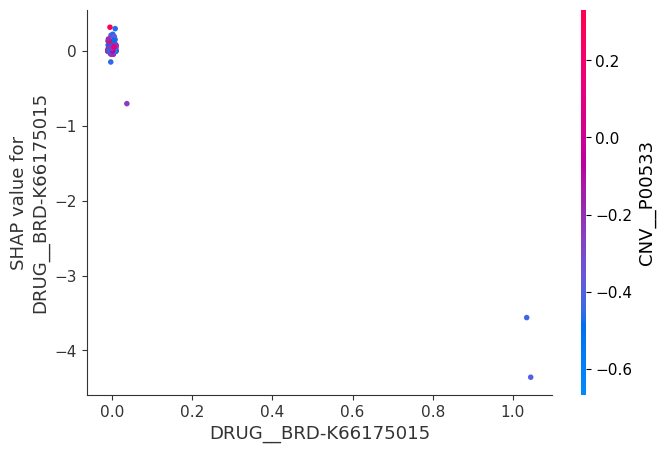

In [25]:
shap.dependence_plot("DRUG__BRD-K66175015", shap_values[feat_idx], test_set, interaction_index='CNV__P00533', x_jitter=0.5)

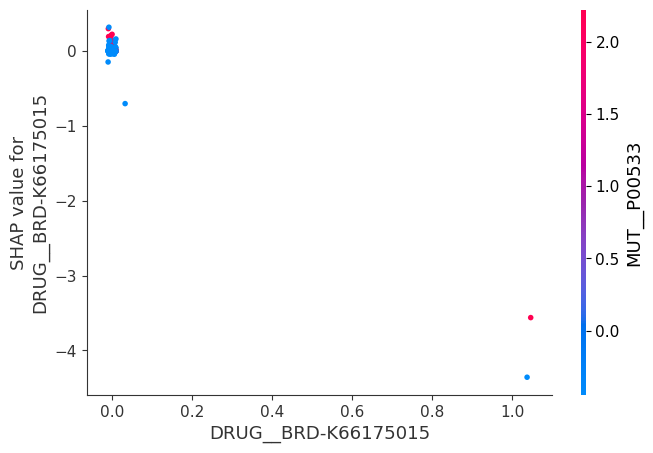

In [26]:
shap.dependence_plot("DRUG__BRD-K66175015", shap_values[feat_idx], test_set, interaction_index='MUT__P00533', x_jitter=0.5)

# Visualizing Ligand Bias 



In [27]:
siginfo = pd.read_csv('../../data/siginfo_beta.txt', low_memory=False, sep='\t')
druginfo = pd.read_csv('../../data/compoundinfo_beta.txt', sep='\t')

In [189]:
geneinfo = pd.read_csv('../extdata/omnipath_uniprot2genesymb.tsv', sep='\t')
geneinfo.head()

From       To
0      Q8NEM1   ZNF680
1      Q9Y496    KIF3A
2      Q6ZWJ1   STXBP4
3      Q8TAM1    BBS10
4  A0A0J9YXM7  TRBJ1-5

In [57]:
druginfo.head()

pert_id      cmap_name target  moa  \
0  BRD-A08715367     L-theanine    NaN  NaN   
1  BRD-A12237696   L-citrulline    NaN  NaN   
2  BRD-A18795974  BRD-A18795974    NaN  NaN   
3  BRD-A27924917  BRD-A27924917    NaN  NaN   
4  BRD-A35931254  BRD-A35931254    NaN  NaN   

                     canonical_smiles                    inchi_key  \
0                CCNC(=O)CCC(N)C(O)=O  DATAGRPVKZEWHA-UHFFFAOYSA-N   
1                NC(CCCNC(N)=O)C(O)=O  RHGKLRLOHDJJDR-UHFFFAOYSA-N   
2          CCCN(CCC)C1CCc2ccc(O)cc2C1  BLYMJBIZMIGWFK-UHFFFAOYSA-N   
3     NCC(O)(CS(O)(=O)=O)c1ccc(Cl)cc1  WBSMZVIMANOCNX-UHFFFAOYSA-N   
4  CN1CCc2cccc-3c2C1Cc1ccc(O)c(O)c-31  VMWNQDUVQKEIOC-UHFFFAOYSA-N   

    compound_aliases  
0         l-theanine  
1       l-citrulline  
2     7-hydroxy-DPAT  
3  2-hydroxysaclofen  
4   r(-)-apomorphine

In [44]:
drugs = ex_smol_df.columns[['DRUG__' in x for x in ex_smol_df.columns]]
hiconc_drug_mask = ex_smol_df[drugs].sum(axis=1).values > 0.
ex_smol_df2 = ex_smol_df.loc[hiconc_drug_mask, :] 
ex_smol_df2.shape

(4586, 156)

In [141]:
x = torch.tensor(ex_smol_df2.values, dtype=torch.float32)

out = EGFR(x)

In [386]:
reducer = umap.UMAP(n_neighbors=15, min_dist=1.) 
u = reducer.fit_transform(out.detach().numpy())

In [387]:
udf = pd.DataFrame(u, columns=['umap1', 'umap2']).assign(sig_id=np.array(sig_ids)[hiconc_drug_mask])
udf = pd.concat((udf, pd.DataFrame(out.detach().numpy(), columns=out_edge_names)), axis=1)
udf = udf.merge(siginfo[['sig_id', 'pert_id', 'cell_iname', 'pert_dose']], on='sig_id', how='left', validate='1:1')
udf = udf.assign(log_pert_dose=np.log10(udf.pert_dose))
brd2cmap = druginfo[lambda x: x.target == 'EGFR'][['pert_id', 'cmap_name']].set_index('pert_id').to_dict()['cmap_name']
udf = udf.assign(cmap_name = [brd2cmap[x] if x in brd2cmap else x for x in udf.pert_id])

# NOTE: redundant outgoing edges. 
cols=pd.Series(udf.columns)
for dup in cols[cols.duplicated()].unique(): 
    cols[cols[cols == dup].index.values.tolist()] = [dup + '.' + str(i) if i != 0 else dup for i in range(sum(cols == dup))]
# rename the columns with the cols list.
udf.columns=cols

udf.head()

umap1     umap2                 sig_id  PROTEIN__P22681  \
0   5.301087  4.622382    ASG002_MCF7_24H:N20        -0.310035   
1  23.026039  3.630180    ASG002_A549_24H:I15        -5.270925   
2  -4.298276  6.225952    ASG002_MCF7_24H:N23        25.570688   
3  -3.558239  0.313782    ASG002_BC3C_24H:F05        25.038465   
4  10.076839  5.481834  ASG002_SNU407_24H:O03        -3.698754   

   PROTEIN__P40763  PROTEIN__P52735  PROTEIN__P42566  PROTEIN__P46108  \
0         4.716174        -7.719988         9.242126         2.866791   
1        -1.225316         3.168153         2.818235        -0.986490   
2        -0.583539       -16.808876         1.335573         8.707556   
3         0.684638        -8.982285        -4.105091         0.198655   
4         0.506587        -2.709341         6.211200         2.108997   

   PROTEIN__P29353  PROTEIN__P42229  ...  RNA__MIMAT0000416  \
0       -11.536545        -0.445578  ...          -1.684555   
1        -5.495777         1.611119  ...           0.178241   
2        -6.131264       -21.773485  ...          10.447680   
3         7.145547       -16.516790  ...          11.070261   
4        -9.671817         0.758909  ...          -1.367119   

   RNA__MIMAT0004494  RNA__MIMAT0000076  RNA__MIMAT0004510  RNA__MIMAT0000095  \
0          -2.513209          -2.115513           1.868652           2.971050   
1          -2.328673           1.448079          -0.821980           2.752855   
2           5.700217          -7.465242          -4.500181          12.456999   
3           5.156760          -5.380518          -1.916967           9.466858   
4          -1.355129           0.122687          -0.166509           2.526564   

         pert_id  cell_iname  pert_dose  log_pert_dose      cmap_name  
0  BRD-K77625799        MCF7   1.000000       0.000000     vandetanib  
1  BRD-K19687926        A549   0.100000      -1.000000      lapatinib  
2  BRD-K66175015        MCF7   1.000000       0.000000       afatinib  
3  BRD-K87909389        BC3C   1.000000       0.000000      alvocidib  
4  BRD-K78431006      SNU407   0.099992      -1.000036  BRD-K78431006  

[5 rows x 115 columns]

In [ ]:
array(['Lapatinib Ditosylate', 'Erlotinib Hydrochloride', 'Cetuximab',
       'Vandetanib', 'Crizotinib', 'Docetaxel', 'Bosutinib',
       'Imatinib Mesylate', 'Afatinib Dimaleate', 'Osimertinib',
       'Ibrutinib', 'Axitinib', 'Necitumumab', 'Dasatinib', 'Gefitinib',
       'Sunitinib Malate', 'Panitumumab'], dtype=object)

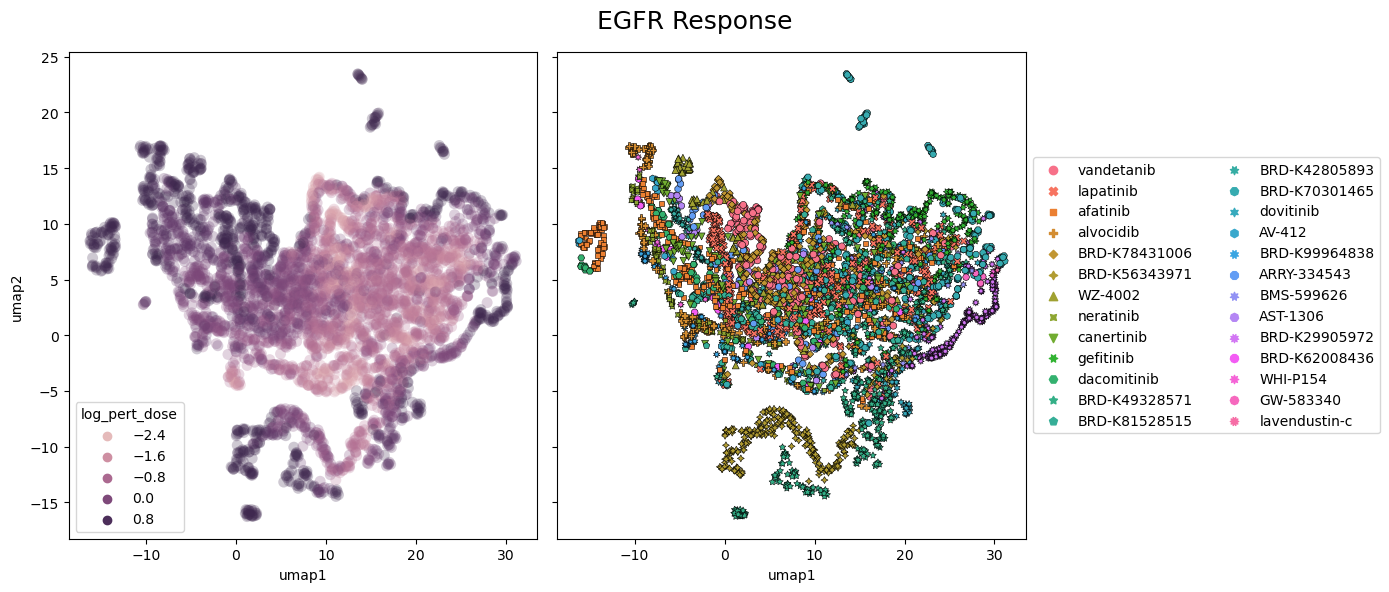

In [430]:
f,axes = plt.subplots(1,2, figsize=(14,6), sharey=True)
sbn.scatterplot(x='umap1', y='umap2', data=udf, hue='log_pert_dose', s=250, ax=axes.flat[0], alpha=0.25, marker='.', linewidth=0)
g = sbn.scatterplot(x='umap1', y='umap2', data=udf, hue='cmap_name', style='cmap_name', alpha=1., ax=axes.flat[1], s=25, edgecolor='k')
g.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=2)

#sbn.scatterplot(x='umap1', y='umap2', data=udf[lambda x: x.cell_iname == 'MCF7'], hue='cmap_name', style='cmap_name', alpha=1., ax=axes.flat[3], s=50, legend=None)
#sbn.scatterplot(x='umap1', y='umap2', data=udf[lambda x: x.cell_iname == 'PC3'], hue='cmap_name', style='cmap_name', alpha=1., ax=axes.flat[4], s=50, legend=None)
#sbn.scatterplot(x='umap1', y='umap2', data=udf[lambda x: x.cell_iname == 'A375'], hue='cmap_name', style='cmap_name', alpha=1., ax=axes.flat[5], s=50, legend=None)
plt.suptitle('EGFR Response', fontsize=18)
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(6,6))
g = sbn.scatterplot(x='umap1', y='umap2', data=udf[lambda x: x.cell_iname == 'A549'], hue='cmap_name', style='cmap_name', alpha=1., size='log_pert_dose', size_norm=(-2,3))
g.legend(loc='center left', bbox_to_anchor=(1.01, 0.5), ncol=2)
plt.show()

In [303]:
udf.groupby('cell_iname').count().sort_values('umap1')

umap1  umap2  sig_id  PROTEIN__P22681  PROTEIN__P40763  \
cell_iname                                                           
NCIH1975        6      6       6                6                6   
VCAP            7      7       7                7                7   
AGS             8      8       8                8                8   
NCIH508         8      8       8                8                8   
NCIH596         9      9       9                9                9   
...           ...    ...     ...              ...              ...   
MDAMB231      224    224     224              224              224   
A549          394    394     394              394              394   
A375          437    437     437              437              437   
PC3           441    441     441              441              441   
MCF7          456    456     456              456              456   

            PROTEIN__P52735  PROTEIN__P42566  PROTEIN__P46108  \
cell_iname                                                      
NCIH1975                  6                6                6   
VCAP                      7                7                7   
AGS                       8                8                8   
NCIH508                   8                8                8   
NCIH596                   9                9                9   
...                     ...              ...              ...   
MDAMB231                224              224              224   
A549                    394              394              394   
A375                    437              437              437   
PC3                     441              441              441   
MCF7                    456              456              456   

            PROTEIN__P29353  PROTEIN__P42229  ...  RNA__MIMAT0031892  \
cell_iname                                    ...                      
NCIH1975                  6                6  ...                  6   
VCAP                      7                7  ...                  7   
AGS                       8                8  ...                  8   
NCIH508                   8                8  ...                  8   
NCIH596                   9                9  ...                  9   
...                     ...              ...  ...                ...   
MDAMB231                224              224  ...                224   
A549                    394              394  ...                394   
A375                    437              437  ...                437   
PC3                     441              441  ...                441   
MCF7                    456              456  ...                456   

            RNA__MIMAT0000416  RNA__MIMAT0004494  RNA__MIMAT0000076  \
cell_iname                                                            
NCIH1975                    6                  6                  6   
VCAP                        7                  7                  7   
AGS                         8                  8                  8   
NCIH508                     8                  8                  8   
NCIH596                     9                  9                  9   
...                       ...                ...                ...   
MDAMB231                  224                224                224   
A549                      394                394                394   
A375                      437                437                437   
PC3                       441                441                441   
MCF7                      456                456                456   

            RNA__MIMAT0004510  RNA__MIMAT0000095  pert_id  pert_dose  \
cell_iname                                                             
NCIH1975                    6                  6        6          6   
VCAP                        7                  7        7          7   
AGS                         8                  8        8          8   
NCIH508                     8     

In [249]:
uni2symb = geneinfo.set_index('From').to_dict()['To']

In [274]:
df = pd.DataFrame(out.detach().numpy(), columns=[x.split('__')[-1] for x in out_edge_names])
df = df.loc[:,~df.columns.duplicated()].copy()
df = df[df.columns[[i for i,x in enumerate(df.columns) if x in uni2symb]]]
df.columns = [uni2symb[x] for x in df.columns]

# zscore 
df -= df.values.mean(axis=0)
df /= (df.values.std(axis=0) + 1e-8)

df.head()

CBL     STAT3      VAV2     EPS15       CRK      SHC1    STAT5A  \
0 -0.342403  1.002613 -0.063178  0.757602  0.109448 -0.459637  0.391374   
1 -0.559902 -0.615851  0.657277  0.102773 -0.245855 -0.157403  0.512653   
2  0.792281 -0.441031 -0.664578 -0.048365  0.648013 -0.189198 -0.866291   
3  0.768947 -0.095579 -0.146702 -0.602967 -0.136575  0.475072 -0.556314   
4 -0.490974 -0.144080  0.268371  0.448640  0.039574 -0.366340  0.462400   

     MAP2K1    STAT5B     STAT1  ...     LAMA2      ABI1     LAMA3     LAMB1  \
0 -0.352306  0.076128 -0.291894  ...  0.467816  0.380523 -0.559756  0.183406   
1 -0.358426 -0.057898 -0.550675  ...  0.630211  0.634857 -0.217378  0.165672   
2  0.063840  0.640149  0.859602  ... -0.373610 -0.628141  0.585394 -0.863281   
3  0.715444 -0.130930  0.614727  ... -0.384254 -0.283720  0.963730 -0.132306   
4 -0.458961  0.142202 -0.427312  ...  0.575274  0.448952 -0.499808 -0.037544   

       MTOR     LAMA1     LAMA5     LAMC3     LAMB3      MMP9  
0 -0.070096  0.434721  0.479913  0.458095  0.358478 -0.040374  
1 -0.745424  0.521572  0.558836  0.551219  0.596087 -0.365943  
2  0.635377 -0.879940 -0.769141 -0.837154 -0.776444  0.851712  
3  0.529778 -0.688412 -0.734225 -0.524805 -0.391293  0.246929  
4 -0.494533  0.418722  0.519323  0.429085  0.368162 -0.110954  

[5 rows x 76 columns]

In [275]:
background = list(df.columns)

In [291]:
genelist = list(df.columns[df.iloc[1].argsort()])[:25]

In [292]:
enr_bg = gp.enrichr(gene_list=genelist,
                 gene_sets=['GO_Biological_Process_2018'],
                 organism='human', # organism argment is ignored because user input a background
                 background=background,
                 outdir=None, # don't write to disk
                )
enr_bg.results.sort_values(by='Adjusted P-value', ascending=True).head()

Gene_set  \
0    GO_Biological_Process_2018   
1    GO_Biological_Process_2018   
280  GO_Biological_Process_2018   
279  GO_Biological_Process_2018   
278  GO_Biological_Process_2018   

                                                  Term   P-value  \
0    positive regulation of protein kinase B signal...  0.000142   
1    regulation of protein kinase B signaling (GO:0...  0.000142   
280  regulation of Arp2/3 complex-mediated actin nu...  0.328947   
279  positive regulation of biosynthetic process (G...  0.328947   
278  regulation of intracellular steroid hormone re...  0.328947   

     Adjusted P-value  Old P-value  Old adjusted P-value  Odds Ratio  \
0            0.049288            0                     0   16.333333   
1            0.049288            0                     0   16.333333   
280          0.556249            0                     0         inf   
279          0.556249            0                     0         inf   
278          0.556249            0                     0         inf   

     Combined Score                                              Genes  
0        144.727151  PIK3CA;EGF;ERBB2;GAB1;PIK3R2;PTPN11;PIK3CB;PIK...  
1        144.727151  PIK3CA;EGF;ERBB2;GAB1;PIK3R2;PTPN11;PIK3CB;PIK...  
280             inf                                              WASF1  
279             inf                                               MTOR  
278             inf                                               ESR1

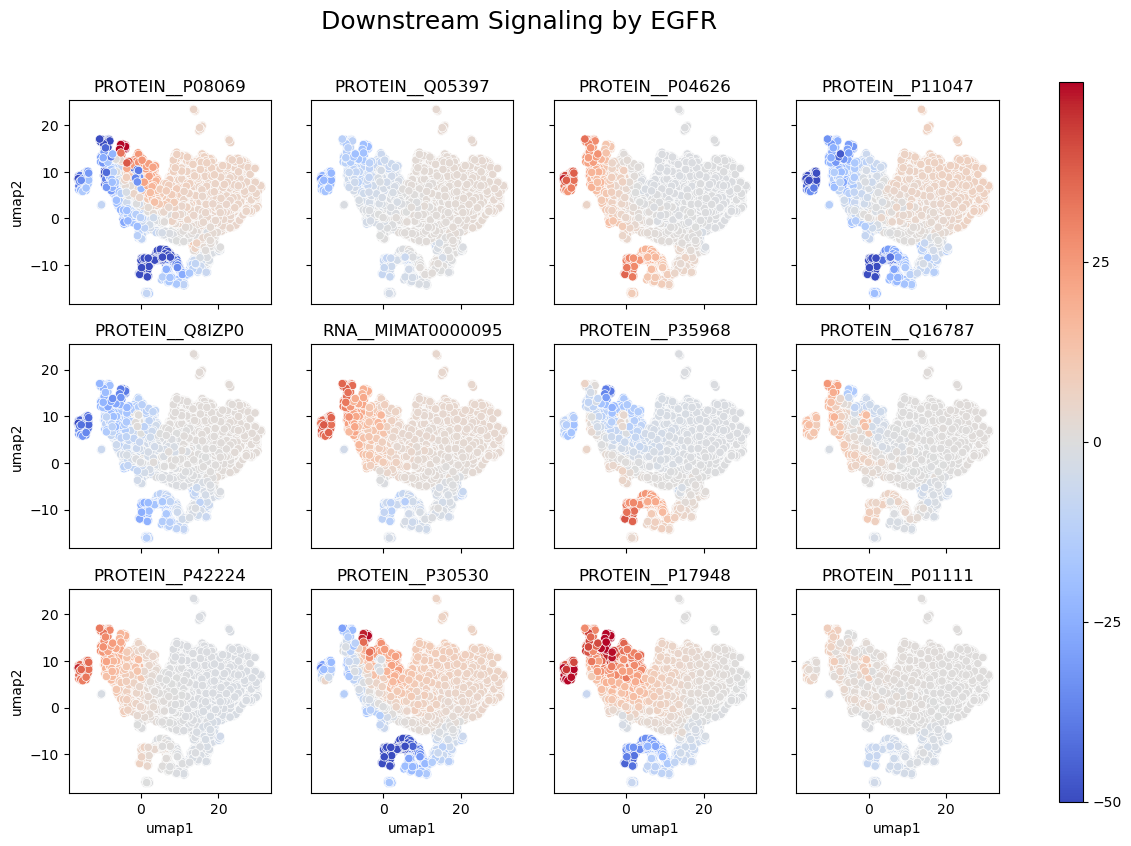

In [418]:
f, axes = plt.subplots(3,4, figsize=(3*4,3*3), sharex=True, sharey=True)
plt.suptitle('Downstream Signaling by EGFR', fontsize=18)
feat_names = np.array(out_edge_names)
np.random.shuffle(feat_names)
for feat, ax in zip(feat_names, axes.flat): 
    vcenter = 0
    vmin, vmax = -50, 50
    normalize = mcolors.TwoSlopeNorm(vcenter=vcenter, vmin=vmin, vmax=vmax)
    g = sbn.scatterplot(x='umap1', y='umap2', data=udf, hue=feat, alpha=1., palette=cm.coolwarm, hue_norm=normalize, ax=ax, legend=None)
    #g.legend(loc='center left', bbox_to_anchor=(1.01, 0.5), ncol=1)
    ax.set_title(feat)

mapable = cm.ScalarMappable(norm=normalize, cmap=cm.coolwarm)
cb_ax = f.add_axes([0.95, 0.1, 0.02, 0.8])
cbar = f.colorbar(mapable, cax=cb_ax)
cbar.set_ticks(np.arange(-50, 50, 25))
#cbar.set_ticklabels(['-50', '0', '+50'])

#plt.tight_layout()

plt.show()

# Binding Affinity analysis 

In [282]:
ex_smol2 = ex_smol
ii = 1
ex_smol2[:, ii] = 5*torch.randn_like(ex_smol2[:, ii])

In [283]:
out2 = EGFR(ex_smol2)

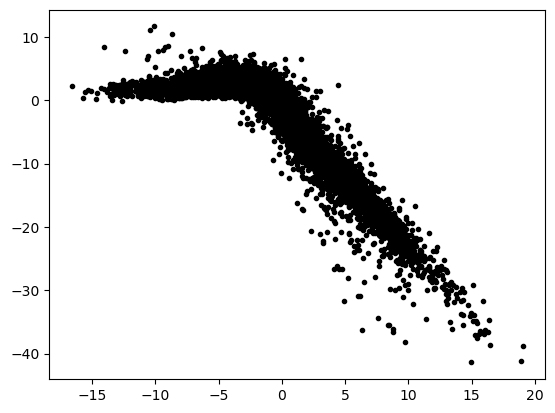

In [284]:
plt.figure() 
plt.plot(ex_smol2[:, ii].detach(), out2[:, 2].detach(), 'k.')
plt.show()

In [104]:
lin1_smol.bias.shape

torch.Size([5])

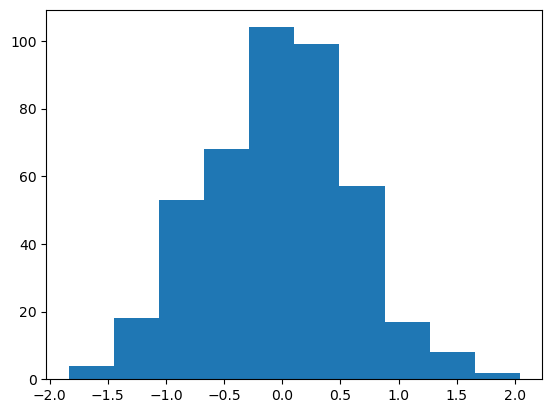

In [93]:
plt.figure()
plt.hist(w1_smol.ravel())
plt.show()

In [77]:
w1_val_smol.size()

torch.Size([430])

In [73]:
np.mean(w1_mask)

0.07037643207855974

In [32]:
drug_idx = data.node_names.tolist().index('DRUG__BRD-A58767537')
row,col = data.edge_index
targ_idx = col[(row == drug_idx).nonzero()[0][0]]
targ_name = data.node_names[targ_idx]

input_idxs = row[col == targ_idx]
output_idxs = col[row == targ_idx]
input_names = data.node_names[input_idxs]
output_names = data.node_names[output_idxs]

hidden_idxs = np.arange(targ_idx*model.channels, targ_idx*model.channels + model.channels) 
print('hidden idxs', hidden_idxs)

print('node:', targ_name)
print('# target inputs:', len(input_names), f'[# drugs: {len([x for x in input_names if "DRUG__" in x])}]')
print('# target outputs:', len(output_names))

hidden idxs [3330 3331 3332 3333 3334]
node: PROTEIN__P00533
# target inputs: 86 [# drugs: 46]
# target outputs: 40


In [ ]:
# 1. node_idx -> edge_idx 
# 2. select W1 idxs subset 
#   2a) convert from sparse -> dense 
# 3. select W2 idxs subset 
#   3a) convert from sparse -> dense 
# 4. select W3 idxs 
#   4a) convert from sparse -> dense 
# 5. convert edge idx to node idx 

# then to run 
# node_idx -> edge_idx 
# select edge_idx inputs (e_smol)
# out = w1_smol @ e_smol .nonlin 
# out = w2_smol @ out .nonlin 
# e_smol = W3_smol @ out 
# edge_idx -> node_idx 



In [ ]:
# node indices -> edge indices
input_edge_idxs = input_idxs[:, ]

In [36]:
# layer 1: (W1)
# create the indices we want to keep 
edges = []
for iidx in input_idxs:
    for hidx in hidden_idxs: 
        edges.append((iidx, hidx))

w1_mask = []
for e in data.edge_index.numpy().T: 
    if tuple(e) in edges: 
        w1_mask.append(True)
    else:
        w1_mask.append(False)

In [37]:
np.mean(w1_mask)

0.0

In [41]:
tuple(e) in edges

False

In [ ]:
def extract_function(model, data, node): 
    ''''''
    # edge input mask


In [3]:
data = torch.load('../output/exp1/proc/Data.pt')

In [4]:
data.node_names

array(['DRUG__BRD-A00758722', 'DRUG__BRD-A00938334',
       'DRUG__BRD-A03249105', ..., 'RNA__Q9Y6Q9', 'RNA__Q9Y6R4',
       'RNA__Q9Y6W5'], dtype='<U19')

In [5]:
B = 100 

x = torch.randn((B, data.node_names.shape[0]))

x.size()

torch.Size([100, 3282])

In [21]:


ex = utils.node2edge(x, model.edge_index)
f = lambda ex: model.edge_update(x=torch.tensor(ex), x0=None, x_last=torch.zeros_like(torch.tensor(ex)).unsqueeze(-1), layer=0)[0].detach().numpy()
ey = f(ex.detach().numpy())
y = utils.edge2node(ey, model.edge_index, output_node_mask=model.output_node_mask)

TypeError: 'int' object is not callable

In [26]:
explainer = shap.Explainer(f, ex[:25, :].detach().numpy())
shap_values = explainer(ex[25:, :].detach().numpy())

ValueError: max_evals=500 is too low for the Permutation explainer, it must be at least 2 * num_features + 1 = 28711!

In [27]:
def extract_function(node, model, data): 
    '''
    extract a single node function from the GSNN model and return the neural network. 
    '''
    C = 3 #model.channels
    node_idx = list(data.node_names).index(node)

    # get first layer weights 
    src, dst = model.lin1.indices
    node_idxs = torch.arange(node_idx*C, node_idx*C + C)
    edge_mask = torch.isin(dst, node_idxs)

    lin1 = copy.deepcopy(model.lin1)
    
    W1 = model.lin1.values[edge_mask]
    B1 = model.lin1.bias[node_idxs] 

    input_names = data.node_names[src[edge_mask]]

    print(input_names)
    print(W1)
    print(B1)

    

In [28]:
extract_function(node='PROTEIN__P26045', model=model, data=data)

IndexError: index 12386 is out of bounds for axis 0 with size 3282

In [21]:
'PROTEIN__P26045' in data.node_names.tolist() 

True